# ESP32 Keyword Spotter, Yes vs No  

1. **Preprocessing**: Membaca audio, normalisasi, dan ekstraksi fitur MFCC (Manual).
2. **Visualisasi Data**: Melihat perbedaan karakteristik sinyal (Waveform, FFT, MFCC) antar kelas.
3. **Model Training**: Melatih Random Forest, Decision Tree, dan KNN.
4. **Evaluasi & Analisis Overfitting**: Menampilkan metrik performa, Confusion Matrix, dan perbandingan Train vs Test.
5. **Deployment**: Mengkonversi model ke format C++ (.h) untuk Arduino.

In [1]:
%pip install librosa numpy pandas scikit-learn micromlgen scipy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from micromlgen import port

BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, 'dataset')


SAMPLE_RATE = 16000
DURATION = 1        
N_FFT = 1024        
HOP_LENGTH = 512    
N_MELS = 32         
N_MFCC = 13        

LABEL_MAP = {'suara_lain': 0, 'yes': 1, 'no': 2}
TARGET_NAMES = ['suara_lain', 'Yes', 'No']

## 1. Visual Karakteristik Suara
Bagian ini membantu kita memahami perbedaan karakteristik audio antara "Yes", "No", dan "suara_lain"

Karakteristik Suara


d:\anaconda\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
d:\anaconda\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


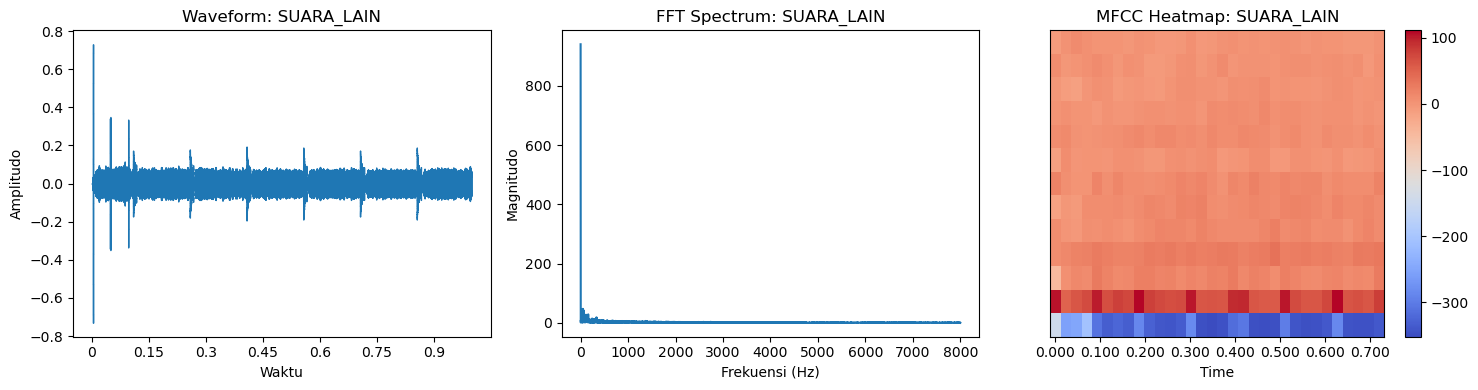

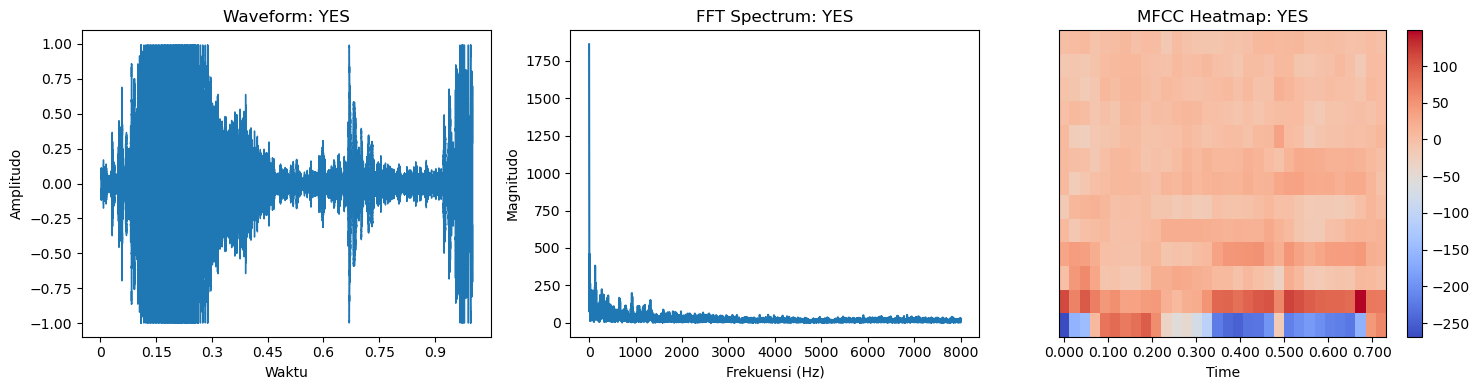

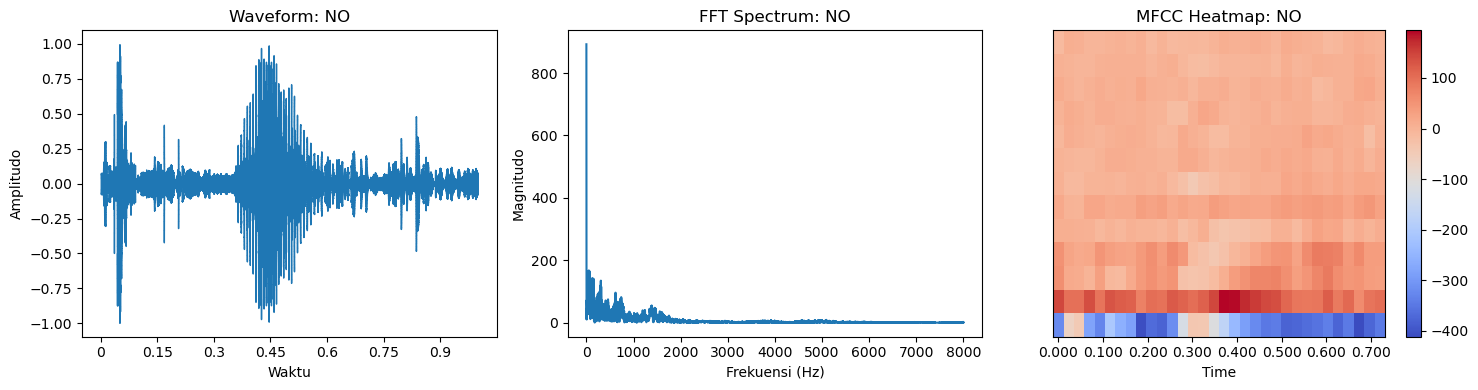

In [3]:
def plot_audio_features(label_name):
    folder = os.path.join(DATASET_PATH, label_name)
    files = glob.glob(os.path.join(folder, '*.wav'))
    
    if not files:
        print(f"❌ Tidak ada file untuk label {label_name}")
        return
    
    # Ambil file pertama sebagai sampel
    file_path = files[0]
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    
    plt.figure(figsize=(15, 4))
    
    # 1. Waveform (Bentuk Gelombang)
    plt.subplot(1, 3, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {label_name.upper()}')
    plt.xlabel('Waktu')
    plt.ylabel('Amplitudo')
    
    # 2. FFT Spectrum (Frekuensi)
    plt.subplot(1, 3, 2)
    fft_res = np.fft.fft(y)
    freqs = np.fft.fftfreq(len(y), 1/sr)
    # Ambil setengah spektrum (positif saja)
    n_half = len(y) // 2
    plt.plot(freqs[:n_half], np.abs(fft_res)[:n_half])
    plt.title(f'FFT Spectrum: {label_name.upper()}')
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Magnitudo')
    
    # 3. MFCC (Fitur Utama)
    plt.subplot(1, 3, 3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC Heatmap: {label_name.upper()}')
    
    plt.tight_layout()
    plt.show()

print("Karakteristik Suara")
for label in LABEL_MAP.keys():
    plot_audio_features(label)

## 2. Persiapan Matematika (Constants)
Kita membuat matriks filter Mel dan DCT secara manual di sini agar nanti bisa diekspor ke `constants.h`.

In [4]:
# A. Mel Filterbank Matrix
mel_filters = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, fmin=0, fmax=SAMPLE_RATE/2)
mel_filters = mel_filters / (np.sum(mel_filters, axis=1, keepdims=True) + 1e-9)

# B. DCT Matrix
dct_matrix = fft.dct(np.eye(N_MELS), type=2, norm='ortho')[:N_MFCC]

print(f" Matriks Mel:  {mel_filters.shape}")
print(f" Matriks DCT:  {dct_matrix.shape}")

 Matriks Mel:  (32, 513)
 Matriks DCT:  (13, 32)


In [5]:
def extract_mfcc_manual(file_path):
    """
    Ekstraksi MFCC Manual (Meniru logika C++ ESP32)
    """
    try:
        # 1. Load Audio
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Padding/Cutting agar pas 1 detik
        target_len = SAMPLE_RATE * DURATION
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)))
        else:
            audio = audio[:target_len]

        # 2. Pre-emphasis (HighPass Filter)
        audio = np.append(audio[0], audio[1:] - 0.97 * audio[:-1])
        
        # 3. STFT -> Power Spectrum
        stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH, window='hann', center=False)
        spectrogram = np.abs(stft)**2
        
        # 4. Mel Spectrogram
        mel_spec = np.dot(mel_filters, spectrogram)
        
        # 5. Log Energy
        log_mel_spec = np.log10(mel_spec + 1e-9)
        
        # 6. DCT (MFCC)
        mfcc = np.dot(dct_matrix, log_mel_spec)
        
        # 7. Global Average (Mean) - output 13 fitur
        return np.mean(mfcc, axis=1)
        
    except Exception as e:
        print(f"Error {file_path}: {e}")
        return None

## 3. Load Dataset & Ekstraksi Fitur

In [6]:
X_data = []
y_data = []

print(" Mulai memproses dataset...")

if not os.path.exists(DATASET_PATH):
    print(f" Folder '{DATASET_PATH}' tidak ditemukan!")
    print(" Pastikan ada 3 folder: 'suara_lain', 'yes', 'no' yang berisi file .wav")
else:
    for label_str, label_int in LABEL_MAP.items():
        folder = os.path.join(DATASET_PATH, label_str)
        files = glob.glob(os.path.join(folder, '*.wav'))
        
        print(f"    {label_str.upper()}: {len(files)} file ditemukan")
        
        for f in files:
            feat = extract_mfcc_manual(f)
            if feat is not None:
                X_data.append(feat)
                y_data.append(label_int)

    X = np.array(X_data)
    y = np.array(y_data)
    print(f"\nTotal data berhasil diproses: {len(X)} sampel")
    print(f"   Shape: {X.shape} (samples, features)")

 Mulai memproses dataset...
    SUARA_LAIN: 30 file ditemukan
    YES: 30 file ditemukan
    NO: 30 file ditemukan

Total data berhasil diproses: 90 sampel
   Shape: (90, 13) (samples, features)


## 4. Training, Evaluasi & Analisis Overfitting
Di sini kita akan:
1. Melatih 3 model (Random Forest, Decision Tree, KNN).
2. Mengecek Akurasi Train vs Test untuk deteksi Overfitting/Underfitting.
3. Menampilkan Confusion Matrix untuk model terbaik.

In [7]:
# Split Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definisi Model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3)
}

best_model_name = ""
best_acc = 0
best_model_obj = None

print("\n HASIL EVALUASI & ANALISIS OVERFITTING")
print("="*80)
print(f"{'MODEL':<20} | {'Test Acc':<10} | {'Train Acc':<10} | {'Gap':<8} | {'Status':<15}")
print("-"*80)

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict Test & Train (untuk cek overfitting)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Hitung Akurasi
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    # Analisis Status
    gap = acc_train - acc_test
    if acc_train < 0.6:
        status = " Underfitting"
    elif gap > 0.15:
        status = " Overfitting"
    else:
        status = " Good Fit"

    print(f"{name:<20} | {acc_test*100:>6.2f}%   | {acc_train*100:>6.2f}%    | {gap*100:>5.2f}% | {status}")

    # Simpan model terbaik berdasarkan Test Accuracy
    if acc_test > best_acc:
        best_acc = acc_test
        best_model_name = name
        best_model_obj = model

print("="*80)
print(f"Akurasi terbaik: {best_model_name} (Akurasi Test: {best_acc*100:.2f}%)")


 HASIL EVALUASI & ANALISIS OVERFITTING
MODEL                | Test Acc   | Train Acc  | Gap      | Status         
--------------------------------------------------------------------------------
Random Forest        | 100.00%   | 100.00%    |  0.00% |  Good Fit
Decision Tree        | 100.00%   | 100.00%    |  0.00% |  Good Fit
KNN (k=3)            |  96.30%   |  96.83%    |  0.53% |  Good Fit
Akurasi terbaik: Random Forest (Akurasi Test: 100.00%)


###  Laporan Detail Model Terbaik


📋 Laporan Detail untuk Random Forest:
              precision    recall  f1-score   support

  suara_lain       1.00      1.00      1.00         9
         Yes       1.00      1.00      1.00         9
          No       1.00      1.00      1.00         9

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



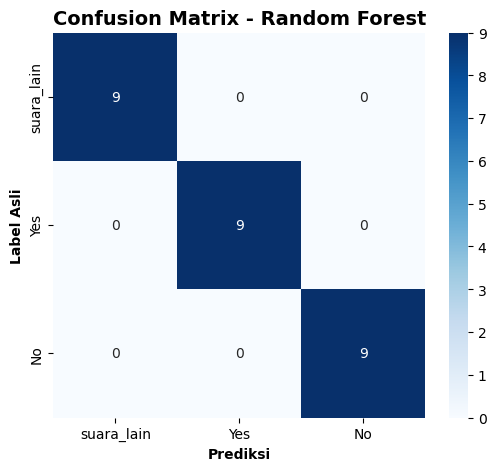

In [8]:
# --- Visualisasi Confusion Matrix Pemenang ---
print(f"\n📋 Laporan Detail untuk {best_model_name}:")
y_final_pred = best_model_obj.predict(X_test)
print(classification_report(y_test, y_final_pred, target_names=TARGET_NAMES))

cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi', fontweight='bold')
plt.ylabel('Label Asli', fontweight='bold')
plt.show()

###  Visualisasi Perbandingan Model

C:\Users\FARELL\AppData\Local\Temp\ipykernel_20824\3910424688.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


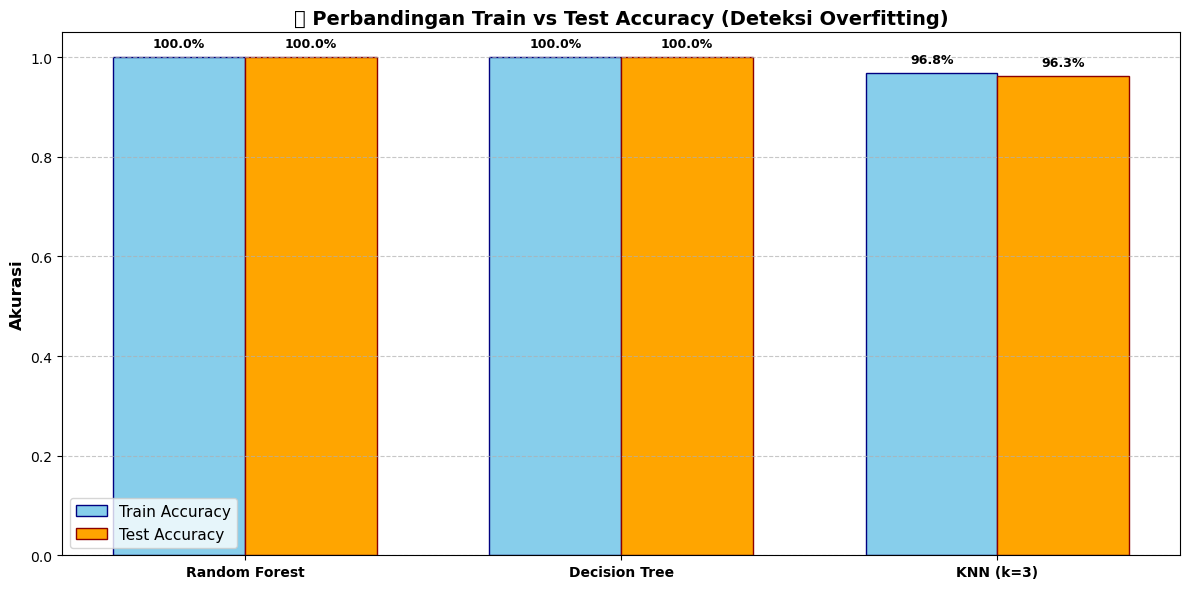

In [9]:
# --- Visualisasi Perbandingan Akurasi (Bar Chart) ---
model_names = list(models.keys())
train_scores = [accuracy_score(y_train, m.predict(X_train)) for m in models.values()]
test_scores = [accuracy_score(y_test, m.predict(X_test)) for m in models.values()]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_scores, width, label='Train Accuracy', color='skyblue', edgecolor='navy')
plt.bar(x + width/2, test_scores, width, label='Test Accuracy', color='orange', edgecolor='darkred')
plt.ylabel('Akurasi', fontweight='bold', fontsize=12)
plt.title('📊 Perbandingan Train vs Test Accuracy (Deteksi Overfitting)', fontweight='bold', fontsize=14)
plt.xticks(x, model_names, fontweight='bold')
plt.ylim([0, 1.05])
plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan nilai di atas bar
for i, v in enumerate(train_scores):
    plt.text(i - width/2, v + 0.02, f'{v*100:.1f}%', ha='center', fontsize=9, fontweight='bold')
for i, v in enumerate(test_scores):
    plt.text(i + width/2, v + 0.02, f'{v*100:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 5.  Generate C++ Headers (Deployment)
Bagian ini akan membuat dua file penting:
1. **`constants.h`**: Berisi matriks matematika MFCC (Mel Filters & DCT).
2. **`model_data.h`**: Berisi kode model C++ dari model pemenang.

In [10]:
# Fungsi Helper: Konversi Array Numpy ke C++ Array String
def to_c_array(name, array, fmt=".6f"):
    s = f"const float {name}[{array.shape[0]}][{array.shape[1]}] = {{\n"
    for row in array:
        s += "  {" + ", ".join([f"{x:{fmt}}" for x in row]) + "},\n"
    s += "};\n"
    return s

# --- FILE 1: constants.h ---
header_content = f"""
#ifndef CONSTANTS_H
#define CONSTANTS_H

// ========================================
// Konfigurasi Audio & FFT untuk ESP32
// ========================================
#define SAMPLE_RATE {SAMPLE_RATE}
#define N_FFT {N_FFT}
#define HOP_LENGTH {HOP_LENGTH}
#define N_MELS {N_MELS}
#define N_MFCC {N_MFCC}
#define SPECTROGRAM_BINS {int(N_FFT/2 + 1)}

// ========================================
// 1. Mel Filterbank Weights
// ========================================
{to_c_array("MEL_FILTERS", mel_filters)}

// ========================================
// 2. DCT Matrix (untuk MFCC)
// ========================================
{to_c_array("DCT_MATRIX", dct_matrix)}

#endif // CONSTANTS_H
"""

with open(os.path.join(BASE_DIR, 'constants.h'), 'w') as f:
    f.write(header_content)
print("File 'constants.h' berhasil dibuat!")


# --- FILE 2: model_data.h ---
model_cpp_code = ""

if "KNN" in best_model_name:
    # KNN butuh ekspor data manual
    print(f"\nℹ Model terbaik adalah KNN. Mengekspor dataset sebagai array C++...")
    k_val = best_model_obj.n_neighbors
    
    model_cpp_code = f"""#ifndef MODEL_DATA_H
#define MODEL_DATA_H

// KNN Model (k={k_val})
#define KNN_K {k_val}
#define KNN_SAMPLES {len(X)}
#define KNN_FEATURES {N_MFCC}

const float knn_X[KNN_SAMPLES][KNN_FEATURES] = {{
"""
    for row in X:
        model_cpp_code += "    {" + ",".join([f"{x:.4f}" for x in row]) + "},\n"
    model_cpp_code += "};\n\n"
    
    model_cpp_code += "const int knn_y[KNN_SAMPLES] = {\n    "
    model_cpp_code += ",".join([str(int(lbl)) for lbl in y])
    model_cpp_code += "\n};\n\n#endif // MODEL_DATA_H\n"

else:
    # Random Forest / Decision Tree bisa pakai micromlgen
    print(f"\nℹMengkonversi {best_model_name} menggunakan micromlgen...")
    try:
        # Classname disesuaikan dengan aplikasi Yes/No
        model_cpp_code = port(best_model_obj, classname="YesNoClassifier")
    except Exception as e:
        print(f" Gagal porting model: {e}")
        model_cpp_code = f"// Error: {e}\n"

with open(os.path.join(BASE_DIR, 'model_data.h'), 'w') as f:
    f.write(model_cpp_code)
    
print(f"File 'model_data.h' berhasil dibuat untuk model: {best_model_name}")
print("\n" + "="*60)
print(" SELESAI! File deployment siap:")
print("    constants.h")
print("    model_data.h")
print("\n Pindahkan kedua file (.h) ini ke folder Sketch Arduino Anda.")
print("="*60)

File 'constants.h' berhasil dibuat!

ℹMengkonversi Random Forest menggunakan micromlgen...
File 'model_data.h' berhasil dibuat untuk model: Random Forest

 SELESAI! File deployment siap:
    constants.h
    model_data.h

 Pindahkan kedua file (.h) ini ke folder Sketch Arduino Anda.


---
##  Catatan Penting

**Interpretasi Status:**
-  **Good Fit**: Model bekerja baik, akurasi train dan test seimbang
-  **Overfitting**: Akurasi train jauh lebih tinggi dari test (gap > 15%)
-  **Underfitting**: Akurasi train masih rendah (< 60%)

**Tips Deployment:**
- Pastikan struktur folder dataset: `dataset/suara_lain/`, `dataset/yes/`, `dataset/no/`
- File audio harus format `.wav` dengan sample rate 16kHz
- Untuk ESP32, gunakan konfigurasi yang sama di Arduino sketch